In [563]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [564]:
df = pd.read_csv("Datasets/features_format_final_clean.csv", parse_dates=["date"])

In [565]:
s_features = ['S1_School closing',
 'S1_IsGeneral',
 'S2_Workplace closing',
 'S2_IsGeneral',
 'S3_Cancel public events',
 'S3_IsGeneral',
 'S4_Close public transport',
 'S4_IsGeneral',
 'S5_Public information campaigns',
 'S5_IsGeneral',
 'S6_Restrictions on internal movement',
 'S6_IsGeneral',
 'S7_International travel controls',
 'S8_Fiscal measures',
 'S9_Monetary measures',
 'S10_Emergency investment in health care',
 'S11_Investment in Vaccines',
 'S12_Testing framework',
 'S13_Contact tracing',
 'StringencyIndex',
 'StringencyIndexForDisplay']

In [566]:
#df = df.drop(columns=s_features)

In [567]:
df["region"] = df["region"].apply(lambda x: "Australia_Region" if x == "Australia" else x)

In [568]:
df = df.sort_values("date")

In [569]:
df = df.drop(columns="country_code")

In [570]:
dummy_country = pd.get_dummies(df["country"])
dummy_region = pd.get_dummies(df["region"])

In [571]:
df = df.drop(columns=["country", "region"])

In [572]:
df = pd.concat([df, dummy_country], axis=1)
df = pd.concat([df, dummy_region], axis=1)

In [573]:
forcast_days = 7
split_date = df["date"].max() - np.timedelta64(forcast_days, 'D')

In [574]:
train = df.loc[df['date'] < split_date]
test = df.loc[df['date'] >= split_date]

train.loc[:, 'date'] = train.date.dt.strftime('%y%m%d')
train.loc[:, 'date'] = train['date'].astype(int)

test.loc[:, 'date'] = test.date.dt.strftime('%y%m%d')
test.loc[:, 'date'] = test['date'].astype(int)

In [576]:
train.head(5)

,date,confirmed,recovered,deaths,S1_School closing,S1_IsGeneral,S2_Workplace closing,S2_IsGeneral,S3_Cancel public events,S3_IsGeneral,...,Africa,Australia_Region,Central Asia,East Asia,Europe,MENA,North America,South America,South Asia,Southeast Asia
0,200122,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0
9048,200122,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
1305,200122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
9135,200122,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,...,0,0,0,0,0,1,0,0,0,0
14094,200122,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,...,0,0,0,0,1,0,0,0,0,0


In [577]:
train_X = train.drop(columns=['confirmed', 'recovered', 'deaths'])

train_y_confirmed = train["confirmed"]
train_y_recovered = train["recovered"]
train_y_deaths = train["deaths"]

test_X = test.drop(columns=['confirmed', 'recovered', 'deaths'])

test_y_confirmed = test["confirmed"]
test_y_recovered = test["recovered"]
test_y_deaths = test["deaths"]

In [581]:
from xgboost import XGBRegressor

In [582]:
model = XGBRegressor(n_estimators=5000)

In [583]:
model.fit(train_X, train_y_confirmed)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=5000, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

Prediction

In [584]:
country = "China"

croatia_test_X = test_X[test_X[country] == 1]

croatia_test_y = list(test_y_confirmed[test_X[country] == 1])

y_pred_cro = model.predict(croatia_test_X)

def MSLE_loss(one, two):
    loss = np.mean((np.log1p(one) - np.log1p(two))**2)  # MSLE loss
    return loss

MSLE_loss(y_pred_cro, croatia_test_y)

In [590]:
y_pred_cro

array([74.00013  , 74.00013  , 74.00013  , 74.00013  , 74.00013  ,
       74.00013  , 74.00013  ,  6.7680655], dtype=float32)

In [591]:
croatia_test_y

[58.0, 73.0, 120.0, 79.0, 93.0, 50.0, 47.0, 357.0]

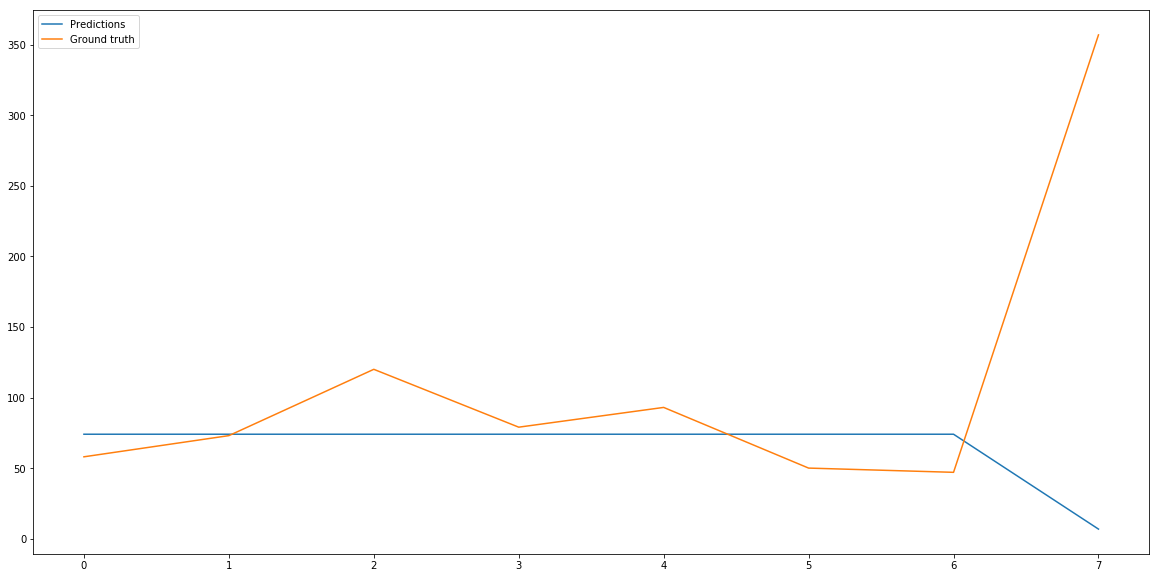

In [592]:
plt.figure(figsize=(20,10))
plt.plot(y_pred_cro, label="Predictions")
plt.plot(croatia_test_y, label="Ground truth")
plt.legend()

In [593]:
y_pred = model.predict(test_X)

In [594]:
MSLE_loss(y_pred, test_y_confirmed)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log1p
  from ipykernel import kernelapp as app


1.3989182081610043

In [643]:
df = pd.read_csv("Datasets/time_variable.csv", parse_dates=["date"])

In [644]:
df2 = pd.read_csv("Datasets/stationary.csv")

In [645]:
df.head(5)

,date,confirmed,recovered,deaths,country_code,StringencyIndex,StringencyIndexForDisplay,cum_cases,cum_recovered,cum_deaths,since_first
0,2020-02-24,1,0,0,AFG,0.0,0.0,1,0,0,0
1,2020-02-25,0,0,0,AFG,0.0,0.0,1,0,0,1
2,2020-02-26,0,0,0,AFG,0.0,0.0,1,0,0,2
3,2020-02-27,0,0,0,AFG,0.0,0.0,1,0,0,3
4,2020-02-28,0,0,0,AFG,0.0,0.0,1,0,0,4
